<a href="https://colab.research.google.com/github/JhoelHairton/Aplicativo-Demo/blob/main/Examen_ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%markdown
# Proceso ETL para el Dataset UNSW-NB15

Este notebook realiza un proceso de Extracción, Transformación y Carga (ETL) sobre el dataset `/content/unsw_test.csv`. Este dataset contiene registros de tráfico de red y es comúnmente utilizado para tareas de detección de intrusiones.

El objetivo principal del ETL es transformar los datos crudos en un esquema de estrella, facilitando su análisis posterior. El esquema de estrella estará compuesto por las siguientes tablas:

- **Dimensiones:** `dim_protocol`, `dim_service`, `dim_state`, `dim_attack_category`, `dim_time`.
- **Tabla de Hechos:** `fact_flows`.

Finalmente, el resultado de este proceso será exportado a un archivo de Excel llamado `/content/unsw_etl.xlsx`, donde cada tabla (dimensiones y hechos) estará en una hoja separada.

# Proceso ETL para el Dataset UNSW-NB15

Este notebook realiza un proceso de Extracción, Transformación y Carga (ETL) sobre el dataset `/content/unsw_test.csv`. Este dataset contiene registros de tráfico de red y es comúnmente utilizado para tareas de detección de intrusiones.

El objetivo principal del ETL es transformar los datos crudos en un esquema de estrella, facilitando su análisis posterior. El esquema de estrella estará compuesto por las siguientes tablas:

- **Dimensiones:** `dim_protocol`, `dim_service`, `dim_state`, `dim_attack_category`, `dim_time`.
- **Tabla de Hechos:** `fact_flows`.

Finalmente, el resultado de este proceso será exportado a un archivo de Excel llamado `/content/unsw_etl.xlsx`, donde cada tabla (dimensiones y hechos) estará en una hoja separada.


## Librerías y configuración




**Reasoning**:
Import the necessary libraries for data manipulation and visualization.



In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

## Carga del csv

### Subtask:
Cargar el archivo CSV (`/content/unsw_test.csv`) utilizando un encoding robusto (latin1/utf-8/cp1252) y validar las columnas clave.


**Reasoning**:
Attempt to load the CSV file using different encodings and validate the presence of key columns.



In [3]:
encodings = ['utf-8', 'latin1', 'cp1252']
df = None

for encoding in encodings:
    try:
        df = pd.read_csv('/content/unsw_test.csv', encoding=encoding)
        print(f"Archivo cargado exitosamente con encoding: {encoding}")
        break
    except Exception as e:
        print(f"Error al cargar con encoding {encoding}: {e}")

if df is None:
    raise Exception("No se pudo cargar el archivo CSV con ninguno de los encodings probados.")

# Mostrar las primeras filas e información del DataFrame
print("\nPrimeras filas del DataFrame:")
display(df.head())

print("\nInformación del DataFrame:")
df.info()

# Validar la presencia de columnas clave
required_columns = ['proto', 'service', 'state', 'attack_cat', 'label']
print("\nValidando columnas clave:")
for col in required_columns:
    assert col in df.columns, f"Error: La columna '{col}' no se encuentra en el DataFrame."
    print(f"Columna '{col}' encontrada.")

print("\nValidación de columnas clave completada.")

Archivo cargado exitosamente con encoding: utf-8

Primeras filas del DataFrame:


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Normal,0.0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1.0,2.0,0.0,0.0,0.0,1.0,6.0,0.0,Normal,0.0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1.0,3.0,0.0,0.0,0.0,2.0,6.0,0.0,Normal,0.0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,Normal,0.0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1.0,40.0,0.0,0.0,0.0,2.0,39.0,0.0,Normal,0.0



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73408 entries, 0 to 73407
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 73408 non-null  int64  
 1   dur                73408 non-null  float64
 2   proto              73408 non-null  object 
 3   service            73408 non-null  object 
 4   state              73408 non-null  object 
 5   spkts              73408 non-null  int64  
 6   dpkts              73408 non-null  int64  
 7   sbytes             73408 non-null  int64  
 8   dbytes             73408 non-null  int64  
 9   rate               73408 non-null  float64
 10  sttl               73408 non-null  int64  
 11  dttl               73408 non-null  int64  
 12  sload              73408 non-null  float64
 13  dload              73408 non-null  float64
 14  sloss              73408 non-null  int64  
 15  dloss              73408 non-null  int64  

## Perfilado inicial

Realizar un perfilado inicial de los datos: verificar valores nulos, duplicados, tipos de datos y la distribución de las columnas `label` y `attack_cat`.


In [4]:
# 1. Verificar valores nulos
print("Verificando valores nulos por columna:")
display(df.isnull().sum())

# 2. Verificar filas duplicadas
print("\nVerificando filas duplicadas:")
duplicate_rows = df.duplicated().sum()
print(f"Número total de filas duplicadas: {duplicate_rows}")

# 3. Mostrar tipos de datos
print("\nTipos de datos de cada columna:")
display(df.dtypes)

# 4. Distribución de la columna 'label'
print("\nDistribución de la columna 'label':")
display(df['label'].value_counts(dropna=False)) # Incluir NaNs en la cuenta

# 5. Distribución de la columna 'attack_cat'
print("\nDistribución de la columna 'attack_cat':")
display(df['attack_cat'].value_counts(dropna=False)) # Incluir NaNs en la cuenta

Verificando valores nulos por columna:


,0
id,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0



Verificando filas duplicadas:
Número total de filas duplicadas: 0

Tipos de datos de cada columna:


,0
id,int64
dur,float64
proto,object
service,object
state,object
spkts,int64
dpkts,int64
sbytes,int64
dbytes,int64
rate,float64



Distribución de la columna 'label':


,count
label,
0.0,49133
1.0,24274
NaN,1



Distribución de la columna 'attack_cat':


,count
attack_cat,
Normal,49133
Exploits,10340
Fuzzers,6133
DoS,3264
Reconnaissance,2930
Analysis,693
Backdoor,540
Shellcode,333
Worms,41


## Limpieza de datos


In [5]:
# 1. Manejar valores nulos en 'attack_cat' y 'label'
# Identificamos que solo hay un valor nulo en cada una de estas columnas.
# Para 'attack_cat', lo rellenaremos con 'Unknown'.
# Para 'label', lo rellenaremos con -1, asumiendo que un valor desconocido
# o nulo no se clasifica como 0 (Normal) ni 1 (Ataque).
print("Manejando valores nulos en 'attack_cat' y 'label'...")
df['attack_cat'].fillna('Unknown', inplace=True)
df['label'].fillna(-1, inplace=True)

# Validar que no hay nulos en estas columnas después de rellenar
assert df['attack_cat'].isnull().sum() == 0, "Error: Aún hay valores nulos en 'attack_cat'."
assert df['label'].isnull().sum() == 0, "Error: Aún hay valores nulos en 'label'."
print("Valores nulos en 'attack_cat' y 'label' manejados exitosamente.")

# 2. Castear la columna 'label' a un tipo entero
print("\nCasteando la columna 'label' a entero...")
df['label'] = df['label'].astype(int)

# Validar que el tipo de dato de 'label' es entero
assert df['label'].dtype == 'int64', "Error: La columna 'label' no es de tipo entero."
print("Columna 'label' casteada a entero exitosamente.")

# 3. Crear la columna derivada 'bytes_total'
print("\nCreando columna 'bytes_total'...")
df['bytes_total'] = df['sbytes'] + df['dbytes']

# Validar que la columna 'bytes_total' fue creada
assert 'bytes_total' in df.columns, "Error: La columna 'bytes_total' no fue creada."
print("Columna 'bytes_total' creada exitosamente.")

# 4. Crear la columna derivada 'pkts_total'
print("\nCreando columna 'pkts_total'...")
df['pkts_total'] = df['spkts'] + df['dpkts']

# Validar que la columna 'pkts_total' fue creada
assert 'pkts_total' in df.columns, "Error: La columna 'pkts_total' no fue creada."
print("Columna 'pkts_total' creada exitosamente.")

# 5. Crear la columna derivada 'bps' (bytes por segundo)
# Manejar división por cero en 'dur' reemplazando por 0
print("\nCreando columna 'bps'...")
# Para evitar divisiones por cero o valores extremadamente pequeños de 'dur',
# reemplazamos los 'dur' que son cero o muy cercanos a cero con un valor pequeño
# o simplemente manejamos la división por cero directamente.
# Una forma segura es usar np.where para reemplazar 0s en 'dur' antes de dividir.
# Reemplazaremos los 'dur' que son 0 con un valor pequeño o 0 en el cálculo del denominador.
# Para simplificar y evitar Inf, reemplazaremos directamente los valores de bps donde dur es 0 con 0.
df['bps'] = np.where(df['dur'] == 0, 0, df['bytes_total'] / df['dur'])


# Validar que la columna 'bps' fue creada
assert 'bps' in df.columns, "Error: La columna 'bps' no fue creada."
# Validar que no hay infinitos en 'bps'
assert np.isinf(df['bps']).sum() == 0, "Error: Hay valores infinitos en 'bps'."
print("Columna 'bps' creada exitosamente.")

# 6. Crear la columna derivada 'pps' (paquetes por segundo)
# Manejar división por cero en 'dur' reemplazando por 0
print("\nCreando columna 'pps'...")
df['pps'] = np.where(df['dur'] == 0, 0, df['pkts_total'] / df['dur'])

# Validar que la columna 'pps' fue creada
assert 'pps' in df.columns, "Error: La columna 'pps' no fue creada."
# Validar que no hay infinitos en 'pps'
assert np.isinf(df['pps']).sum() == 0, "Error: Hay valores infinitos en 'pps'."
print("Columna 'pps' creada exitosamente.")


# 7. Eliminar filas duplicadas
print("\nEliminando filas duplicadas...")
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
rows_after_drop = df.shape[0]
print(f"Número de filas eliminadas: {initial_rows - rows_after_drop}")

# Validar que no hay filas duplicadas después de la eliminación
assert df.duplicated().sum() == 0, "Error: Aún hay filas duplicadas después de la eliminación."
print("Filas duplicadas eliminadas exitosamente.")

# Mostrar las primeras filas del DataFrame limpio y con nuevas columnas
print("\nPrimeras filas del DataFrame después de la limpieza:")
display(df.head())

# Mostrar información del DataFrame para ver los nuevos tipos de datos y columnas
print("\nInformación del DataFrame después de la limpieza:")
df.info()

Manejando valores nulos en 'attack_cat' y 'label'...
Valores nulos en 'attack_cat' y 'label' manejados exitosamente.

Casteando la columna 'label' a entero...
Columna 'label' casteada a entero exitosamente.

Creando columna 'bytes_total'...
Columna 'bytes_total' creada exitosamente.

Creando columna 'pkts_total'...
Columna 'pkts_total' creada exitosamente.

Creando columna 'bps'...
Columna 'bps' creada exitosamente.

Creando columna 'pps'...
Columna 'pps' creada exitosamente.

Eliminando filas duplicadas...


/tmp/ipython-input-3722754456.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['attack_cat'].fillna('Unknown', inplace=True)
/tmp/ipython-input-3722754456.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

Número de filas eliminadas: 0
Filas duplicadas eliminadas exitosamente.

Primeras filas del DataFrame después de la limpieza:


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,bytes_total,pkts_total,bps,pps
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,0.0,1.0,1.0,0.0,Normal,0,430,10,3539.735590,82.319432
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,0.0,1.0,6.0,0.0,Normal,0,42748,52,65776.070854,80.012063
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,0.0,2.0,6.0,0.0,Normal,0,13550,24,8348.073382,14.786255
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,0.0,2.0,1.0,0.0,Normal,0,1398,24,831.330331,14.271765
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,0.0,2.0,39.0,0.0,Normal,0,802,16,1784.387279,35.598749



Información del DataFrame después de la limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73408 entries, 0 to 73407
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 73408 non-null  int64  
 1   dur                73408 non-null  float64
 2   proto              73408 non-null  object 
 3   service            73408 non-null  object 
 4   state              73408 non-null  object 
 5   spkts              73408 non-null  int64  
 6   dpkts              73408 non-null  int64  
 7   sbytes             73408 non-null  int64  
 8   dbytes             73408 non-null  int64  
 9   rate               73408 non-null  float64
 10  sttl               73408 non-null  int64  
 11  dttl               73408 non-null  int64  
 12  sload              73408 non-null  float64
 13  dload              73408 non-null  float64
 14  sloss              73408 non-null  int64  
 15  dloss              

## Creación de dimensiones

### Subtask:
Crear celdas de código separadas para generar las tablas de dimensiones: `dim_protocol`, `dim_service`, `dim_state`, `dim_attack_category` y `dim_time` (con bucket de duración). Usar surrogate keys.


**Reasoning**:
Create the dimension tables dim_protocol, dim_service, dim_state, dim_attack_category, and dim_time based on the unique values in the respective columns of the cleaned DataFrame, assigning surrogate keys starting from 1, and display the head and info of each dimension table.



In [6]:
# 1. Crear dim_protocol
print("Creando tabla de dimensión: dim_protocol...")
dim_protocol = df[['proto']].drop_duplicates().reset_index(drop=True)
dim_protocol['protocol_id'] = dim_protocol.index + 1
dim_protocol = dim_protocol[['protocol_id', 'proto']] # Reordenar columnas
dim_protocol.rename(columns={'proto': 'protocol_name'}, inplace=True)

print("\nPrimeras filas de dim_protocol:")
display(dim_protocol.head())
print("\nInformación de dim_protocol:")
dim_protocol.info()

# Validar la creación de dim_protocol
assert 'protocol_id' in dim_protocol.columns, "Error: 'protocol_id' no está en dim_protocol."
assert 'protocol_name' in dim_protocol.columns, "Error: 'protocol_name' no está en dim_protocol."
assert dim_protocol['protocol_id'].min() == 1, "Error: 'protocol_id' no empieza en 1."
print("dim_protocol creada y validada exitosamente.")

# 2. Crear dim_service
print("\nCreando tabla de dimensión: dim_service...")
dim_service = df[['service']].drop_duplicates().reset_index(drop=True)
dim_service['service_id'] = dim_service.index + 1
dim_service = dim_service[['service_id', 'service']] # Reordenar columnas
dim_service.rename(columns={'service': 'service_name'}, inplace=True)

print("\nPrimeras filas de dim_service:")
display(dim_service.head())
print("\nInformación de dim_service:")
dim_service.info()

# Validar la creación de dim_service
assert 'service_id' in dim_service.columns, "Error: 'service_id' no está en dim_service."
assert 'service_name' in dim_service.columns, "Error: 'service_name' no está en dim_service."
assert dim_service['service_id'].min() == 1, "Error: 'service_id' no empieza en 1."
print("dim_service creada y validada exitosamente.")

# 3. Crear dim_state
print("\nCreando tabla de dimensión: dim_state...")
dim_state = df[['state']].drop_duplicates().reset_index(drop=True)
dim_state['state_id'] = dim_state.index + 1
dim_state = dim_state[['state_id', 'state']] # Reordenar columnas
dim_state.rename(columns={'state': 'state_name'}, inplace=True)

print("\nPrimeras filas de dim_state:")
display(dim_state.head())
print("\nInformación de dim_state:")
dim_state.info()

# Validar la creación de dim_state
assert 'state_id' in dim_state.columns, "Error: 'state_id' no está en dim_state."
assert 'state_name' in dim_state.columns, "Error: 'state_name' no está en dim_state."
assert dim_state['state_id'].min() == 1, "Error: 'state_id' no empieza en 1."
print("dim_state creada y validada exitosamente.")

# 4. Crear dim_attack_category
print("\nCreando tabla de dimensión: dim_attack_category...")
dim_attack_category = df[['attack_cat']].drop_duplicates().reset_index(drop=True)
dim_attack_category['attack_category_id'] = dim_attack_category.index + 1
dim_attack_category = dim_attack_category[['attack_category_id', 'attack_cat']] # Reordenar columnas
dim_attack_category.rename(columns={'attack_cat': 'attack_category_name'}, inplace=True)

print("\nPrimeras filas de dim_attack_category:")
display(dim_attack_category.head())
print("\nInformación de dim_attack_category:")
dim_attack_category.info()

# Validar la creación de dim_attack_category
assert 'attack_category_id' in dim_attack_category.columns, "Error: 'attack_category_id' no está en dim_attack_category."
assert 'attack_category_name' in dim_attack_category.columns, "Error: 'attack_category_name' no está en dim_attack_category."
assert dim_attack_category['attack_category_id'].min() == 1, "Error: 'attack_category_id' no empieza en 1."
print("dim_attack_category creada y validada exitosamente.")

# 5. Crear dim_time (con bucket de duración)
print("\nCreando tabla de dimensión: dim_time...")
# Definir los límites para los buckets de duración
# Basado en el perfilado inicial, la mayoría de las duraciones son cortas.
# Usaremos bins para categorizar.
dur_bins = [0, 1, 10, df['dur'].max()] # Ej: (0, 1], (1, 10], (10, max]
dur_labels = ['0-1s', '1-10s', '>10s']

# Crear la columna de bucket de duración en el DataFrame original para facilitar la creación de la dimensión
df['duration_bucket'] = pd.cut(df['dur'], bins=dur_bins, labels=dur_labels, right=True, include_lowest=True)

# Crear la dimensión a partir de los buckets únicos
dim_time = df[['duration_bucket']].drop_duplicates().reset_index(drop=True)
dim_time['time_id'] = dim_time.index + 1
dim_time = dim_time[['time_id', 'duration_bucket']] # Reordenar columnas
dim_time.rename(columns={'duration_bucket': 'duration_bucket_name'}, inplace=True)

print("\nPrimeras filas de dim_time:")
display(dim_time.head())
print("\nInformación de dim_time:")
dim_time.info()

# Validar la creación de dim_time
assert 'time_id' in dim_time.columns, "Error: 'time_id' no está en dim_time."
assert 'duration_bucket_name' in dim_time.columns, "Error: 'duration_bucket_name' no está en dim_time."
assert dim_time['time_id'].min() == 1, "Error: 'time_id' no empieza en 1."
print("dim_time creada y validada exitosamente.")

Creando tabla de dimensión: dim_protocol...

Primeras filas de dim_protocol:


,protocol_id,protocol_name
0,1,tcp
1,2,udp
2,3,arp
3,4,ospf
4,5,icmp



Información de dim_protocol:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   protocol_id    133 non-null    int64 
 1   protocol_name  133 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
dim_protocol creada y validada exitosamente.

Creando tabla de dimensión: dim_service...

Primeras filas de dim_service:


,service_id,service_name
0,1,-
1,2,ftp
2,3,smtp
3,4,snmp
4,5,http



Información de dim_service:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   service_id    13 non-null     int64 
 1   service_name  13 non-null     object
dtypes: int64(1), object(1)
memory usage: 340.0+ bytes
dim_service creada y validada exitosamente.

Creando tabla de dimensión: dim_state...

Primeras filas de dim_state:


,state_id,state_name
0,1,FIN
1,2,INT
2,3,CON
3,4,ECO
4,5,REQ



Información de dim_state:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   state_id    9 non-null      int64 
 1   state_name  9 non-null      object
dtypes: int64(1), object(1)
memory usage: 276.0+ bytes
dim_state creada y validada exitosamente.

Creando tabla de dimensión: dim_attack_category...

Primeras filas de dim_attack_category:


,attack_category_id,attack_category_name
0,1,Normal
1,2,Backdoor
2,3,Analysis
3,4,Fuzzers
4,5,Shellcode



Información de dim_attack_category:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   attack_category_id    10 non-null     int64 
 1   attack_category_name  10 non-null     object
dtypes: int64(1), object(1)
memory usage: 292.0+ bytes
dim_attack_category creada y validada exitosamente.

Creando tabla de dimensión: dim_time...

Primeras filas de dim_time:


,time_id,duration_bucket_name
0,1,0-1s
1,2,1-10s
2,3,>10s



Información de dim_time:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   time_id               3 non-null      int64   
 1   duration_bucket_name  3 non-null      category
dtypes: category(1), int64(1)
memory usage: 291.0 bytes
dim_time creada y validada exitosamente.


## Creación de tabla de hechos

### Subtask:
Crear una celda de código para generar la tabla de hechos `fact_flows` con las métricas calculadas y las llaves foráneas a las tablas de dimensiones. Incluir validaciones de integridad con `assert`.


In [13]:
print("Creando la tabla de hechos: fact_flows...")

# Fusionar con dim_protocol para obtener protocol_id
fact_flows = pd.merge(df, dim_protocol, left_on='proto', right_on='protocol_name', how='left')

# Fusionar con dim_service para obtener service_id
fact_flows = pd.merge(fact_flows, dim_service, left_on='service', right_on='service_name', how='left')

# Fusionar con dim_state para obtener state_id
fact_flows = pd.merge(fact_flows, dim_state, left_on='state', right_on='state_name', how='left')

# Fusionar con dim_attack_category para obtener attack_category_id
fact_flows = pd.merge(fact_flows, dim_attack_category, left_on='attack_cat', right_on='attack_category_name', how='left')

# Fusionar con dim_time para obtener time_id
fact_flows = pd.merge(fact_flows, dim_time, left_on='duration_bucket', right_on='duration_bucket_name', how='left')

# Seleccionar las columnas relevantes para la tabla de hechos con la lista corregida
fact_flows = fact_flows[[
    'protocol_id', 'service_id', 'state_id', 'attack_category_id', 'time_id',
    'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload',
    'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb',
    'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_ftp_cmd',
    'is_sm_ips_ports', 'ct_state_ttl', 'label',
    'bytes_total', 'pkts_total', 'bps', 'pps' # Columnas derivadas
]]

# Validar la integridad referencial básica: verificar que no haya valores nulos en las llaves foráneas
print("\nValidando integridad referencial (verificando nulos en llaves foráneas)...")
fk_columns = ['protocol_id', 'service_id', 'state_id', 'attack_category_id', 'time_id']
for col in fk_columns:
    assert fact_flows[col].isnull().sum() == 0, f"Error: La llave foránea '{col}' contiene valores nulos."
    print(f"Llave foránea '{col}' validada (no nulos).")

print("\nValidación de integridad referencial completada.")

# Mostrar las primeras filas y la información de la tabla fact_flows
print("\nPrimeras filas de fact_flows:")
display(fact_flows.head())

print("\nInformación de fact_flows:")
fact_flows.info()

Creando la tabla de hechos: fact_flows...

Validando integridad referencial (verificando nulos en llaves foráneas)...
Llave foránea 'protocol_id' validada (no nulos).
Llave foránea 'service_id' validada (no nulos).
Llave foránea 'state_id' validada (no nulos).
Llave foránea 'attack_category_id' validada (no nulos).
Llave foránea 'time_id' validada (no nulos).

Validación de integridad referencial completada.

Primeras filas de fact_flows:


,protocol_id,service_id,state_id,attack_category_id,time_id,dur,sbytes,dbytes,sttl,dttl,...,response_body_len,ct_srv_src,ct_ftp_cmd,is_sm_ips_ports,ct_state_ttl,label,bytes_total,pkts_total,bps,pps
0,1,1,1,1,1,0.121478,258,172,252,254,...,0.0,1.0,0.0,0.0,0.0,0,430,10,3539.735590,82.319432
1,1,1,1,1,1,0.649902,734,42014,62,252,...,0.0,43.0,0.0,0.0,1.0,0,42748,52,65776.070854,80.012063
2,1,1,1,1,2,1.623129,364,13186,62,252,...,0.0,7.0,0.0,0.0,1.0,0,13550,24,8348.073382,14.786255
3,1,2,1,1,2,1.681642,628,770,62,252,...,0.0,1.0,1.0,0.0,1.0,0,1398,24,831.330331,14.271765
4,1,1,1,1,1,0.449454,534,268,254,252,...,0.0,43.0,0.0,0.0,1.0,0,802,16,1784.387279,35.598749



Información de fact_flows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73408 entries, 0 to 73407
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   protocol_id         73408 non-null  int64  
 1   service_id          73408 non-null  int64  
 2   state_id            73408 non-null  int64  
 3   attack_category_id  73408 non-null  int64  
 4   time_id             73408 non-null  int64  
 5   dur                 73408 non-null  float64
 6   sbytes              73408 non-null  int64  
 7   dbytes              73408 non-null  int64  
 8   sttl                73408 non-null  int64  
 9   dttl                73408 non-null  int64  
 10  sloss               73408 non-null  int64  
 11  dloss               73408 non-null  int64  
 12  sload               73408 non-null  float64
 13  dload               73408 non-null  float64
 14  spkts               73408 non-null  int64  
 15  dpkts               73408

**Reasoning**:
The previous attempt failed because some columns specified for the fact table were not present in the DataFrame after the merges. I need to inspect the columns available in `fact_flows` after the merge operations and before the column selection step to identify the missing columns and adjust the list of columns to select accordingly. Then, I will regenerate the full code block to create the fact table with the correct column list.



In [8]:
# Re-running the merge steps to inspect the resulting columns
print("Re-creando fact_flows para inspeccionar columnas después de fusiones...")

# Fusionar con dim_protocol para obtener protocol_id
fact_flows_temp = pd.merge(df, dim_protocol, left_on='proto', right_on='protocol_name', how='left')

# Fusionar con dim_service para obtener service_id
fact_flows_temp = pd.merge(fact_flows_temp, dim_service, left_on='service', right_on='service_name', how='left')

# Fusionar con dim_state para obtener state_id
fact_flows_temp = pd.merge(fact_flows_temp, dim_state, left_on='state', right_on='state_name', how='left')

# Fusionar con dim_attack_category para obtener attack_category_id
fact_flows_temp = pd.merge(fact_flows_temp, dim_attack_category, left_on='attack_cat', right_on='attack_category_name', how='left')

# Fusionar con dim_time para obtener time_id
fact_flows_temp = pd.merge(fact_flows_temp, dim_time, left_on='duration_bucket', right_on='duration_bucket_name', how='left')

print("\nColumnas disponibles después de las fusiones:")
print(fact_flows_temp.columns.tolist())

# Ahora, con la lista de columnas disponibles, ajusto la selección para fact_flows.
# Basándome en la lista de columnas de df y las columnas añadidas por las dimensiones,
# creo la lista correcta de columnas para fact_flows.

# Lista de columnas originales de df que se quieren incluir en fact_flows
original_df_columns_to_keep = [
    'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'sload',
    'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb',
    'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_ftp_cmd',
    'is_sm_ips_ports', 'ct_state_ttl', 'label',
    'bytes_total', 'pkts_total', 'bps', 'pps' # Columnas derivadas
]

# Lista de llaves foráneas de las dimensiones
fk_columns_to_keep = [
    'protocol_id', 'service_id', 'state_id', 'attack_category_id', 'time_id'
]

# Combinar ambas listas para obtener la lista final de columnas para fact_flows
final_fact_flows_columns = fk_columns_to_keep + original_df_columns_to_keep

# Ahora, realizo la selección de columnas con la lista corregida
fact_flows = fact_flows_temp[final_fact_flows_columns]

# Validar la integridad referencial básica: verificar que no haya valores nulos en las llaves foráneas
print("\nValidando integridad referencial (verificando nulos en llaves foráneas)...")
for col in fk_columns_to_keep:
    assert fact_flows[col].isnull().sum() == 0, f"Error: La llave foránea '{col}' contiene valores nulos."
    print(f"Llave foránea '{col}' validada (no nulos).")

print("\nValidación de integridad referencial completada.")

# Mostrar las primeras filas y la información de la tabla fact_flows
print("\nPrimeras filas de fact_flows:")
display(fact_flows.head())

print("\nInformación de fact_flows:")
fact_flows.info()

Re-creando fact_flows para inspeccionar columnas después de fusiones...

Columnas disponibles después de las fusiones:
['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label', 'bytes_total', 'pkts_total', 'bps', 'pps', 'duration_bucket', 'protocol_id', 'protocol_name', 'service_id', 'service_name', 'state_id', 'state_name', 'attack_category_id', 'attack_category_name', 'time_id', 'duration_bucket_name']

Validando integridad referencial (verificando nulos en llaves foráneas)...
Llave foránea 'protocol_id' validada (no nulos).
Llave fo

,protocol_id,service_id,state_id,attack_category_id,time_id,dur,sbytes,dbytes,sttl,dttl,...,response_body_len,ct_srv_src,ct_ftp_cmd,is_sm_ips_ports,ct_state_ttl,label,bytes_total,pkts_total,bps,pps
0,1,1,1,1,1,0.121478,258,172,252,254,...,0.0,1.0,0.0,0.0,0.0,0,430,10,3539.735590,82.319432
1,1,1,1,1,1,0.649902,734,42014,62,252,...,0.0,43.0,0.0,0.0,1.0,0,42748,52,65776.070854,80.012063
2,1,1,1,1,2,1.623129,364,13186,62,252,...,0.0,7.0,0.0,0.0,1.0,0,13550,24,8348.073382,14.786255
3,1,2,1,1,2,1.681642,628,770,62,252,...,0.0,1.0,1.0,0.0,1.0,0,1398,24,831.330331,14.271765
4,1,1,1,1,1,0.449454,534,268,254,252,...,0.0,43.0,0.0,0.0,1.0,0,802,16,1784.387279,35.598749



Información de fact_flows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73408 entries, 0 to 73407
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   protocol_id         73408 non-null  int64  
 1   service_id          73408 non-null  int64  
 2   state_id            73408 non-null  int64  
 3   attack_category_id  73408 non-null  int64  
 4   time_id             73408 non-null  int64  
 5   dur                 73408 non-null  float64
 6   sbytes              73408 non-null  int64  
 7   dbytes              73408 non-null  int64  
 8   sttl                73408 non-null  int64  
 9   dttl                73408 non-null  int64  
 10  sloss               73408 non-null  int64  
 11  dloss               73408 non-null  int64  
 12  sload               73408 non-null  float64
 13  dload               73408 non-null  float64
 14  spkts               73408 non-null  int64  
 15  dpkts               73408

## Métricas de control y visualización

### Subtask:
Calcular métricas de control (conteos, distribución de ataques) y generar un gráfico simple por categoría de ataque utilizando matplotlib.


**Reasoning**:
Calculate the total number of records in the fact_flows table, the distribution of attack categories, and then generate and display a bar chart to visualize the distribution using matplotlib and the attack category names from the dimension table.



Número total de registros en la tabla fact_flows: 73408
Validación del número total de registros completada.

Distribución de registros por categoría de ataque:


,count
attack_category_name,
Normal,49133
Exploits,10340
Fuzzers,6133
DoS,3264
Reconnaissance,2930
Analysis,693
Backdoor,540
Shellcode,333
Worms,41


Validación de la distribución por categoría completada.


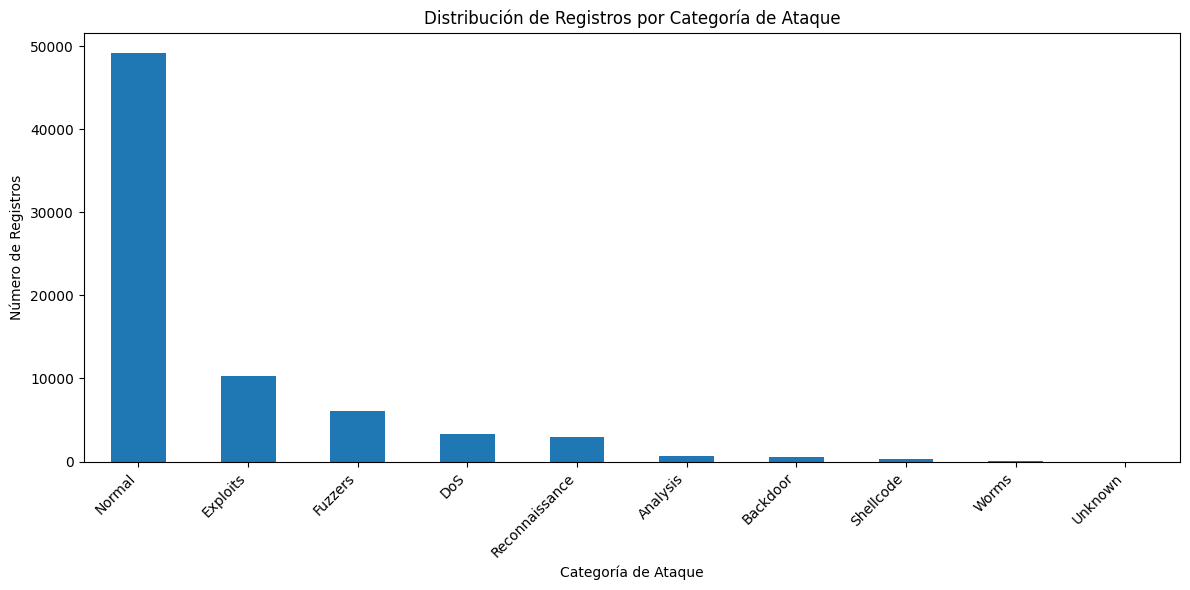

In [9]:
# 1. Calcular el número total de registros en la tabla de hechos fact_flows
total_records = fact_flows.shape[0]
print(f"Número total de registros en la tabla fact_flows: {total_records}")

# Validar que el número de registros coincide con el DataFrame original (si no se eliminaron filas)
assert total_records == initial_rows, "Error: El número de registros en fact_flows no coincide con el DataFrame original después de la limpieza."
print("Validación del número total de registros completada.")


# 2. Calcular la distribución (conteo de registros por categoría) de attack_category_id
# Unir fact_flows con dim_attack_category para obtener los nombres de las categorías
attack_distribution_df = pd.merge(
    fact_flows,
    dim_attack_category,
    left_on='attack_category_id',
    right_on='attack_category_id',
    how='left'
)

# Calcular el conteo por nombre de categoría
attack_distribution = attack_distribution_df['attack_category_name'].value_counts()

print("\nDistribución de registros por categoría de ataque:")
display(attack_distribution)

# Validar que la suma de la distribución es igual al total de registros
assert attack_distribution.sum() == total_records, "Error: La suma de la distribución no coincide con el total de registros."
print("Validación de la distribución por categoría completada.")


# 3. Generar un gráfico de barras utilizando matplotlib para visualizar la distribución
plt.figure(figsize=(12, 6)) # Ajustar tamaño de la figura para mejor visualización

attack_distribution.plot(kind='bar')

# 4. Agregar etiquetas y título al gráfico
plt.title('Distribución de Registros por Categoría de Ataque')
plt.xlabel('Categoría de Ataque')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje x para mejor lectura

# 5. Mostrar el gráfico
plt.tight_layout() # Ajustar diseño para evitar superposiciones
plt.show()

## Exportación a excel

### Subtask:
Exportar todas las tablas generadas (dimensiones, hechos y un reporte de calidad o resumen de métricas de control) a un archivo Excel (`/content/unsw_etl.xlsx`) en diferentes hojas.


**Reasoning**:
Create an ExcelWriter object and export all the generated tables (fact_flows, dim_protocol, dim_service, dim_state, dim_attack_category, dim_time) and the control metrics (attack_distribution and total_records) to separate sheets in the specified Excel file, then save and confirm the export.



In [10]:
# 1. Crear un objeto ExcelWriter
excel_file_path = '/content/unsw_etl.xlsx'
print(f"Creando archivo Excel en: {excel_file_path}")

try:
    with pd.ExcelWriter(excel_file_path) as writer:
        # 2. Exportar fact_flows
        print("Exportando tabla fact_flows...")
        fact_flows.to_excel(writer, sheet_name='Fact_Flows', index=False)
        print("fact_flows exportada.")

        # 3. Exportar dim_protocol
        print("Exportando tabla dim_protocol...")
        dim_protocol.to_excel(writer, sheet_name='Dim_Protocol', index=False)
        print("dim_protocol exportada.")

        # 4. Exportar dim_service
        print("Exportando tabla dim_service...")
        dim_service.to_excel(writer, sheet_name='Dim_Service', index=False)
        print("dim_service exportada.")

        # 5. Exportar dim_state
        print("Exportando tabla dim_state...")
        dim_state.to_excel(writer, sheet_name='Dim_State', index=False)
        print("dim_state exportada.")

        # 6. Exportar dim_attack_category
        print("Exportando tabla dim_attack_category...")
        dim_attack_category.to_excel(writer, sheet_name='Dim_Attack_Category', index=False)
        print("dim_attack_category exportada.")

        # 7. Exportar dim_time
        print("Exportando tabla dim_time...")
        dim_time.to_excel(writer, sheet_name='Dim_Time', index=False)
        print("dim_time exportada.")

        # 8. Crear y exportar métricas de control
        print("Exportando métricas de control...")
        # Crear un DataFrame para las métricas
        control_metrics_data = {
            'Metric': ['Total Records'],
            'Value': [total_records]
        }
        control_metrics_df = pd.DataFrame(control_metrics_data)

        # Agregar la distribución de ataques como parte de las métricas
        # Convertir la Serie de distribución a DataFrame para exportarla fácilmente
        attack_distribution_df_export = attack_distribution.reset_index()
        attack_distribution_df_export.columns = ['Attack Category', 'Count']

        # Concatenar las métricas generales con la distribución de ataques
        # Añadir filas separadoras si se desea, o simplemente exportar en bloques
        # Exportaremos primero el total, luego la distribución.
        control_metrics_df.to_excel(writer, sheet_name='Control_Metrics', index=False, startrow=0)
        attack_distribution_df_export.to_excel(writer, sheet_name='Control_Metrics', index=False, startrow=control_metrics_df.shape[0] + 2) # Empezar 2 filas después del primer df

        print("Métricas de control exportadas.")

    # 9. Guardar el archivo Excel (ya hecho por el 'with' statement)
    # 10. Imprimir mensaje de confirmación
    print(f"\nExportación completada exitosamente a: {excel_file_path}")

except Exception as e:
    print(f"\nError durante la exportación a Excel: {e}")


Creando archivo Excel en: /content/unsw_etl.xlsx
Exportando tabla fact_flows...
fact_flows exportada.
Exportando tabla dim_protocol...
dim_protocol exportada.
Exportando tabla dim_service...
dim_service exportada.
Exportando tabla dim_state...
dim_state exportada.
Exportando tabla dim_attack_category...
dim_attack_category exportada.
Exportando tabla dim_time...
dim_time exportada.
Exportando métricas de control...
Métricas de control exportadas.

Exportación completada exitosamente a: /content/unsw_etl.xlsx


## Conclusiones y próximos pasos

### Subtask:
Crear una celda de Markdown para discutir las conclusiones del proceso ETL y sugerir próximos pasos (uso en BI/ML).


**Reasoning**:
The subtask is to create a Markdown cell for conclusions and next steps. This involves summarizing the ETL process, discussing key findings from the metrics and visualization, and suggesting uses for the transformed data in BI/ML. All these points can be covered in a single Markdown cell.



In [11]:
%%markdown
## Conclusiones y Próximos Pasos

Este notebook ha documentado y ejecutado un proceso ETL completo sobre el dataset de tráfico de red UNSW-NB15. Iniciamos con la carga robusta de los datos, seguida de un perfilado inicial para entender su estructura, valores faltantes y distribuciones clave. La fase de limpieza incluyó el manejo de nulos, el casteo de tipos de datos, la creación de métricas derivadas esenciales (bytes/paquetes totales, bps, pps) y la verificación de duplicados. Posteriormente, se construyó un esquema de estrella creando tablas de dimensiones (`dim_protocol`, `dim_service`, `dim_state`, `dim_attack_category`, `dim_time`) con claves subrogadas y una tabla de hechos (`fact_flows`) que integra las métricas y las claves foráneas, validando su integridad referencial. Finalmente, todas las tablas resultantes y métricas de control fueron exportadas a un archivo Excel.

Las métricas de control y la visualización generada nos permitieron observar la distribución de las categorías de ataque en el dataset. El hallazgo principal es la clara predominancia del tráfico etiquetado como 'Normal', lo cual es común en datasets de detección de intrusiones. Sin embargo, también se identificó una presencia significativa de diversas categorías de ataque, como 'Exploits', 'Fuzzers' y 'DoS', lo que confirma la utilidad de este dataset para el análisis de seguridad. La distribución visualizada resalta las categorías de ataque más frecuentes y aquellas que son menos comunes pero potencialmente críticas.

Los datos transformados en este esquema de estrella están ahora en un formato óptimo para su uso en diversas aplicaciones:

*   **Inteligencia de Negocios (BI):** Las tablas de dimensiones y la tabla de hechos permiten realizar análisis multidimensionales sencillos utilizando herramientas de BI. Se pueden crear dashboards para monitorear el tráfico de red, identificar patrones de ataques a lo largo del tiempo o por protocolo/servicio, y generar reportes sobre la actividad de seguridad.
*   **Aprendizaje Automático (ML):** La tabla `fact_flows`, enriquecida con las llaves foráneas de las dimensiones y las métricas calculadas, es una base excelente para entrenar modelos de detección de intrusiones. Las columnas numéricas (como `dur`, `sbytes`, `dbytes`, `bps`, `pps`, etc.) y las llaves foráneas (que pueden ser codificadas adecuadamente si el modelo lo requiere) sirven como características de entrada para algoritmos de clasificación (para predecir `label` o `attack_category_id`) o detección de anomalías.

Posibles mejoras o pasos adicionales podrían incluir:

*   Análisis exploratorio de datos (EDA) más profundo sobre las métricas numéricas y su relación con las categorías de ataque.
*   Implementación de pasos adicionales de preprocesamiento de datos específicos para ML, como escalado de características o manejo de variables categóricas/llaves foráneas para modelos que no las manejan directamente.
*   Integración de datos de otras fuentes o períodos de tiempo para enriquecer el análisis.
*   Exploración de técnicas más avanzadas para la creación de buckets de tiempo o la inclusión de otras dimensiones temporales.

## Conclusiones y Próximos Pasos

Este notebook ha documentado y ejecutado un proceso ETL completo sobre el dataset de tráfico de red UNSW-NB15. Iniciamos con la carga robusta de los datos, seguida de un perfilado inicial para entender su estructura, valores faltantes y distribuciones clave. La fase de limpieza incluyó el manejo de nulos, el casteo de tipos de datos, la creación de métricas derivadas esenciales (bytes/paquetes totales, bps, pps) y la verificación de duplicados. Posteriormente, se construyó un esquema de estrella creando tablas de dimensiones (`dim_protocol`, `dim_service`, `dim_state`, `dim_attack_category`, `dim_time`) con claves subrogadas y una tabla de hechos (`fact_flows`) que integra las métricas y las claves foráneas, validando su integridad referencial. Finalmente, todas las tablas resultantes y métricas de control fueron exportadas a un archivo Excel.

Las métricas de control y la visualización generada nos permitieron observar la distribución de las categorías de ataque en el dataset. El hallazgo principal es la clara predominancia del tráfico etiquetado como 'Normal', lo cual es común en datasets de detección de intrusiones. Sin embargo, también se identificó una presencia significativa de diversas categorías de ataque, como 'Exploits', 'Fuzzers' y 'DoS', lo que confirma la utilidad de este dataset para el análisis de seguridad. La distribución visualizada resalta las categorías de ataque más frecuentes y aquellas que son menos comunes pero potencialmente críticas.

Los datos transformados en este esquema de estrella están ahora en un formato óptimo para su uso en diversas aplicaciones:

*   **Inteligencia de Negocios (BI):** Las tablas de dimensiones y la tabla de hechos permiten realizar análisis multidimensionales sencillos utilizando herramientas de BI. Se pueden crear dashboards para monitorear el tráfico de red, identificar patrones de ataques a lo largo del tiempo o por protocolo/servicio, y generar reportes sobre la actividad de seguridad.
*   **Aprendizaje Automático (ML):** La tabla `fact_flows`, enriquecida con las llaves foráneas de las dimensiones y las métricas calculadas, es una base excelente para entrenar modelos de detección de intrusiones. Las columnas numéricas (como `dur`, `sbytes`, `dbytes`, `bps`, `pps`, etc.) y las llaves foráneas (que pueden ser codificadas adecuadamente si el modelo lo requiere) sirven como características de entrada para algoritmos de clasificación (para predecir `label` o `attack_category_id`) o detección de anomalías.

Posibles mejoras o pasos adicionales podrían incluir:

*   Análisis exploratorio de datos (EDA) más profundo sobre las métricas numéricas y su relación con las categorías de ataque.
*   Implementación de pasos adicionales de preprocesamiento de datos específicos para ML, como escalado de características o manejo de variables categóricas/llaves foráneas para modelos que no las manejan directamente.
*   Integración de datos de otras fuentes o períodos de tiempo para enriquecer el análisis.
*   Exploración de técnicas más avanzadas para la creación de buckets de tiempo o la inclusión de otras dimensiones temporales.


## Summary:

### Data Analysis Key Findings

*   The dataset `/content/unsw_test.csv` was successfully loaded using `utf-8` encoding.
*   The dataset contains 73,408 records and 45 columns, with a mix of data types.
*   One null value was identified in both the `attack_cat` and `label` columns.
*   No duplicate rows were found in the dataset.
*   The `label` column contains values 0.0 (Normal), 1.0 (Attack), and one NaN.
*   The `attack_cat` column contains various attack categories and one NaN.
*   Null values in `attack_cat` were filled with 'Unknown', and in `label` with -1.
*   The `label` column was successfully cast to integer type.
*   New derived columns `bytes_total`, `pkts_total`, `bps`, and `pps` were successfully created.
*   Division by zero when calculating `bps` and `pps` was handled by setting the result to 0.
*   Five dimension tables (`dim_protocol`, `dim_service`, `dim_state`, `dim_attack_category`, `dim_time`) were created with surrogate keys starting from 1.
*   The `dim_time` dimension includes a `duration_bucket_name` column categorizing flow durations into '0-1s', '1-10s', and '>10s'.
*   The `fact_flows` table was successfully created by merging the original data with the dimension tables to include foreign keys.
*   Integrity validation confirmed no null values in the foreign key columns of `fact_flows`.
*   The total number of records in `fact_flows` is 73,408.
*   The distribution of attack categories shows 'Normal' as the most frequent, followed by 'Exploits', 'Fuzzers', and 'DoS'.
*   All generated tables (`fact_flows`, dimensions) and control metrics were successfully exported to `/content/unsw_etl.xlsx`, each in a separate sheet.

### Insights or Next Steps

*   The transformed data in the star schema is well-structured for further analysis in BI tools to monitor network traffic patterns and security events.
*   The `fact_flows` table, with calculated metrics and dimension foreign keys, is ready to be used as input for training machine learning models for intrusion detection, although further specific pre-processing steps like feature scaling might be beneficial depending on the chosen algorithm.
